In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#plt.imshow(mnist.train.images[0].reshape((28, 28)))

np.where(mnist.train.labels == 7)[0][0:10]

array([ 0, 14, 22, 25, 35, 49, 57, 59, 68, 89])

In [411]:
def build_graph(batch_size = 10, input_features = 784, filter_size = 10):
    A = tf.placeholder(dtype=tf.float32, shape=(batch_size, input_features), name="A")
    B = tf.placeholder(dtype=tf.float32, shape=(batch_size, input_features), name="B")
    labels = tf.placeholder(dtype=tf.float32, shape=(batch_size), name="labels")
    hidden_features = 7 * 7 * filter_size
    out_features = 50
    
    fc_weights = tf.Variable(np.random.randn(hidden_features, out_features), dtype=tf.float32)
    b = tf.Variable(np.random.randn(out_features), dtype=tf.float32)

    filter1 = tf.Variable(np.random.randn(3, 3, 1, filter_size), dtype=tf.float32)
    filter2 = tf.Variable(np.random.randn(3, 3, 10, filter_size), dtype=tf.float32)
    
    Ax = tf.reshape(A, [batch_size, 28, 28, 1])
    Bx = tf.reshape(B, [batch_size, 28, 28, 1])
    
    A_conv1 = tf.nn.leaky_relu(tf.nn.conv2d(Ax, filter1, [1, 1, 1, 1], "SAME"))
    A_pool1 = tf.layers.max_pooling2d(inputs=A_conv1, pool_size=[2, 2], strides=2)
    
    B_conv1 = tf.nn.leaky_relu(tf.nn.conv2d(Bx, filter1, [1, 1, 1, 1], "SAME"))
    B_pool1 = tf.layers.max_pooling2d(inputs=B_conv1, pool_size=[2, 2], strides=2)
    
    A_conv2 = tf.nn.leaky_relu(tf.nn.conv2d(A_pool1, filter2, [1, 1, 1, 1], "SAME"))
    A_pool2 = tf.layers.max_pooling2d(inputs=A_conv2, pool_size=[2, 2], strides=2)
    
    B_conv2 = tf.nn.leaky_relu(tf.nn.conv2d(B_pool1, filter2, [1, 1, 1, 1], "SAME"))
    B_pool2 = tf.layers.max_pooling2d(inputs=B_conv2, pool_size=[2, 2], strides=2)
    
    
    Fa = tf.reshape(A_pool2, [batch_size, hidden_features])
    Fb = tf.reshape(B_pool2, [batch_size, hidden_features])
    
    Fa = tf.nn.xw_plus_b(Fa, fc_weights, b)
    Fb = tf.nn.xw_plus_b(Fb, fc_weights, b)

    embeddings_A = tf.nn.l2_normalize(Fa, axis=1)
    embeddings_B = tf.nn.l2_normalize(Fb, axis=1)
    
    dist = tf.pow(embeddings_A - embeddings_B, 2)
    dist = tf.reduce_sum(dist, 1)
        
    loss = tf.contrib.losses.metric_learning.contrastive_loss(labels, embeddings_A, embeddings_B, margin=0.5)
    
    return A, B, labels, loss, embeddings_A, dist

build_graph()

(<tf.Tensor 'A_1:0' shape=(10, 784) dtype=float32>,
 <tf.Tensor 'B_1:0' shape=(10, 784) dtype=float32>,
 <tf.Tensor 'labels_1:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'contrastive_loss_1:0' shape=() dtype=float32>,
 <tf.Tensor 'l2_normalize_2:0' shape=(10, 50) dtype=float32>,
 <tf.Tensor 'Sum_2:0' shape=(10,) dtype=float32>)

In [256]:
def generate_samples(n = 1, D=mnist.train):
    while True:
        idxA = np.random.randint(D.labels.shape[0], size=n)
        idxB = np.random.randint(D.labels.shape[0], size=n)
        if (np.intersect1d(idxA, idxB).shape[0] == 0):
            break
    similar = (D.labels[idxA] == D.labels[idxB]).astype(np.float32)
    return D.images[idxA], D.images[idxB], similar

generate_samples(n = 10)

(array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32),
 array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.], dtype=float32))

In [412]:
batch_size = 100
tf.reset_default_graph()
with tf.Session() as s:
    A, B, labels, loss, _, dist = build_graph(batch_size=batch_size);
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    train_step = optimizer.minimize(loss)
    
    s.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    for i in range(5000):
        Aim, Bim, Lim = generate_samples(n=batch_size)
        loss_, _, dist_ = s.run([loss, train_step, dist], feed_dict={
            A: Aim,
            B: Bim,
            labels: Lim
        })
        if i % 100 == 0:
            Aim, Bim, Lim = generate_samples(n=batch_size, D=mnist.test)
            test_loss = s.run(loss, feed_dict={
                A: Aim,
                B: Bim,
                labels: Lim
            })
            print("Loss (train/test): ({:6.4f}/{:6.4f})".format(loss_, test_loss))
            
    save_path = saver.save(s, "./model.ckpt")
    print("Model saved in path: {:s}".format(save_path))

Loss (train/test): (0.0214/0.0091)
Loss (train/test): (0.0165/0.0186)
Loss (train/test): (0.0137/0.0191)
Loss (train/test): (0.0167/0.0121)
Loss (train/test): (0.0166/0.0176)
Loss (train/test): (0.0212/0.0189)
Loss (train/test): (0.0130/0.0186)
Loss (train/test): (0.0219/0.0134)
Loss (train/test): (0.0244/0.0143)
Loss (train/test): (0.0175/0.0172)
Loss (train/test): (0.0280/0.0129)
Loss (train/test): (0.0169/0.0169)
Loss (train/test): (0.0089/0.0157)
Loss (train/test): (0.0153/0.0149)
Loss (train/test): (0.0107/0.0177)
Loss (train/test): (0.0159/0.0148)
Loss (train/test): (0.0145/0.0057)
Loss (train/test): (0.0112/0.0119)
Loss (train/test): (0.0146/0.0109)
Loss (train/test): (0.0104/0.0061)
Loss (train/test): (0.0169/0.0082)
Loss (train/test): (0.0093/0.0155)
Loss (train/test): (0.0123/0.0102)
Loss (train/test): (0.0075/0.0091)
Loss (train/test): (0.0168/0.0140)
Loss (train/test): (0.0097/0.0076)
Loss (train/test): (0.0152/0.0155)
Loss (train/test): (0.0116/0.0119)
Loss (train/test): (

In [413]:
def build_embeddings(data):
    with tf.Session(graph=tf.Graph()) as s:
        A, B, labels, loss, embeddings, _ = build_graph(batch_size=data.shape[0]);
        saver = tf.train.Saver()
        saver.restore(s, "./model.ckpt")
        return s.run(embeddings, feed_dict={
            A: data
        })
    
test_embeddings = build_embeddings(mnist.test.images)
train_embeddings = build_embeddings(mnist.train.images)

print(test_embeddings.shape)

INFO:tensorflow:Restoring parameters from ./model.ckpt
INFO:tensorflow:Restoring parameters from ./model.ckpt
(10000, 50)


Пробуем кластеризовать результаты при помощи Knn

In [8]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

In [57]:
nn = NearestNeighbors(n_neighbors=11).fit(mnist.train.images)

In [98]:
idx = nn.kneighbors(mnist.test.images[0:1000], return_distance=False)
pred = np.array([np.argmax(np.bincount(row)) for row in mnist.train.labels[idx]])

print(accuracy_score(mnist.test.labels[0:1000], pred))

0.948


Теперь пробуем то же самое на вложениях полученных с использованием NN

In [414]:
nnEmb = NearestNeighbors(n_neighbors=11).fit(train_embeddings)

In [415]:
idx = nnEmb.kneighbors(test_embeddings[0:1000], return_distance=False)
pred = np.array([np.argmax(np.bincount(row)) for row in mnist.train.labels[idx]])

print(accuracy_score(mnist.test.labels[0:1000], pred))

0.978


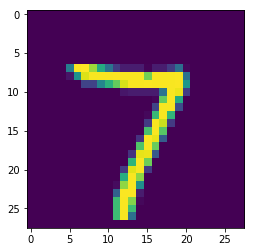

In [416]:
plt.imshow(mnist.train.images[idx[0][9]].reshape(28, 28))

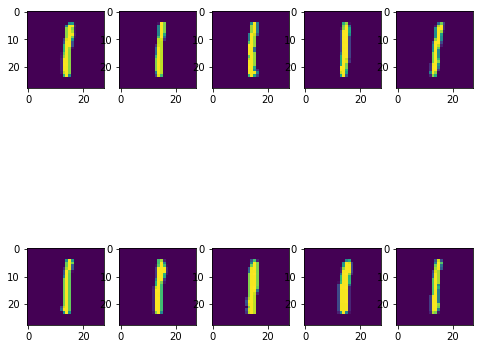

In [452]:
import numpy as np
import matplotlib.pyplot as plt

im_to_show=178
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(mnist.test.images[im_to_show].reshape(28, 28))
for i in range(2, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(mnist.train.images[idx[im_to_show][i]].reshape(28, 28))
plt.show()